# J2118 SED analysis

In [1]:
import os, time, pdb
import numpy as np

In [2]:
import fsps
import sedpy
import prospect

In [3]:
from matplotlib.pylab import *

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.8, palette='Set2')
%matplotlib inline

In [6]:
verbose = True
zcontinuous = 1

### Data

In [7]:
#vega2ab = [2.699, 3.339, 5.174, 6.620]
#mag = 10**(-0.4*(14.8739+2.699))
#sig = 2.5 * 0.0154054/14.8739 / np.log(10)
#mag, 1/sig**2
#print(sig, 1/np.sqrt(5.61366e+17))

In [8]:
def load_obs(snr=10):
    """
    From Christy:
      W1      14.8739    0.0154054
      W2      14.1342    0.0283280
      W3      10.4872    0.0699660
      W4      8.02651     0.179578
    """
    from prospect.utils.obsutils import fix_obs    

    phot = dict(
        FUV=(1.82491e-09, 1.15115e+19),
        NUV=(8.06441e-09, 2.25963e+19),
        u=(1.27666e-08, 1.53319e+18),
        g=(1.59991e-08, 7.47418e+18),
        r=(3.15573e-08, 2.18797e+18),
        i=(3.63049e-08, 1.53877e+18),
        z=(4.14564e-08, 2.71207e+17),
        ch1=(9.25971e-08, 3.91873e+17),
        ch2=(9.67009e-08, 3.54276e+17),
        W1=(9.40651e-08, 5.61366e+17),
        W2=(1.02882e-07, 1.38784e+17),
        W3=(5.44324e-07, 8.12757e+14),
        W4=(1.38524e-06, 1.90498e+13))    

    galex = ['galex_FUV', 'galex_NUV']
    sdss = ['sdss_{}0'.format(b) for b in ['u','g','r','i','z']]
    spitzer = ['spitzer_irac_ch{}'.format(n) for n in ['1','2']]
    wise = ['wise_w{}'.format(n) for n in ['1','2', '3', '4']]
    filternames = galex + sdss + spitzer + wise

    obs = {}
    obs['redshift'] = 0.535
    obs["filters"] = sedpy.observate.load_filters(filternames)

    obs["maggies"] = np.array([phot[filt][0] for filt in phot.keys()])
    obs["maggies_unc"] = np.array([1/np.sqrt(phot[filt][1]) for filt in phot.keys()])

    # mask out W4
    #obs["phot_mask"] = np.array(['w4' in f.name for f in obs["filters"]])    
    
    # we will also create a handy vector of effective wavelengths, though this is not required
    obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]
    obs["wavelength"] = None  # this would be a vector of wavelengths in angstroms if we had 
    obs["spectrum"] = None
    obs['unc'] = None  #spectral uncertainties are given here
    obs['mask'] = None
    obs = fix_obs(obs)
    return obs

In [9]:
obs = load_obs()
obs

{'redshift': 0.535,
 'filters': [<class 'sedpy.observate.Filter'>(galex_FUV),
  <class 'sedpy.observate.Filter'>(galex_NUV),
  <class 'sedpy.observate.Filter'>(sdss_u0),
  <class 'sedpy.observate.Filter'>(sdss_g0),
  <class 'sedpy.observate.Filter'>(sdss_r0),
  <class 'sedpy.observate.Filter'>(sdss_i0),
  <class 'sedpy.observate.Filter'>(sdss_z0),
  <class 'sedpy.observate.Filter'>(spitzer_irac_ch1),
  <class 'sedpy.observate.Filter'>(spitzer_irac_ch2),
  <class 'sedpy.observate.Filter'>(wise_w1),
  <class 'sedpy.observate.Filter'>(wise_w2),
  <class 'sedpy.observate.Filter'>(wise_w3),
  <class 'sedpy.observate.Filter'>(wise_w4)],
 'maggies': array([1.82491e-09, 8.06441e-09, 1.27666e-08, 1.59991e-08, 3.15573e-08,
        3.63049e-08, 4.14564e-08, 9.25971e-08, 9.67009e-08, 9.40651e-08,
        1.02882e-07, 5.44324e-07, 1.38524e-06]),
 'maggies_unc': array([2.94736581e-10, 2.10368802e-10, 8.07610601e-10, 3.65778541e-10,
        6.76050781e-10, 8.06144963e-10, 1.92021365e-09, 1.59745020e-

In [10]:
run_params = {}
run_params['redshift'] = obs['redshift']
run_params["zcontinuous"] = zcontinuous
run_params["verbose"] = verbose

### Model

In [11]:
def load_model(obs):
    
    from prospect.models import priors
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary["parametric_sfh"]
    
    # fixed redshift
    model_params["zred"]['isfree'] = False
    model_params["zred"]['init'] = obs['redshift']
        
    # fixed metallicity
    model_params["logzsol"]["isfree"] = False
    model_params["logzsol"]['init'] = 0.019

    # Adjust model initial values
    model_params["mass"]["init"] = 3e11
    model_params["tau"]["init"] = 10.0
    model_params["tage"]["init"] = 1.0
    model_params["dust2"]["init"] = 1.0
    
    # adjust priors
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e10, maxi=1e12)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e8
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 0.05
    
    # Add dust emission (with fixed dust SED parameters)
    model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model using this new dictionary of parameter specifications
    model = SedModel(model_params)

    return model

In [12]:
model = load_model(obs)

In [13]:
model.theta_labels

<bound method ProspectorParams.theta_labels of :::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10000000000.0,maxi=1000000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=1,maxi=100.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.535 
  logzsol: 0.019 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 >

In [14]:
def load_sps(zcontinuous=1):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

In [15]:
def lnprobfn(theta, nested=False, verbose=verbose):
    """
    Given a parameter vector, a dictionary of observational data 
    a model object, and an sps object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.

    """
    from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    t1 = time.time()
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
    d1 = time.time() - t1
 
    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)
    d2 = time.time() - t2
    if verbose:
        write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec

In [27]:
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    
    """
    from prospect.likelihood import chi_spec, chi_phot
    
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return -np.infty

    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    
    return np.concatenate([chispec, chiphot])

In [17]:
%time sps = load_sps(zcontinuous=zcontinuous)

CPU times: user 10.4 s, sys: 729 ms, total: 11.1 s
Wall time: 11.2 s


In [18]:
theta = model.theta.copy()
theta[model.theta_index["mass"]] = 1e8
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)

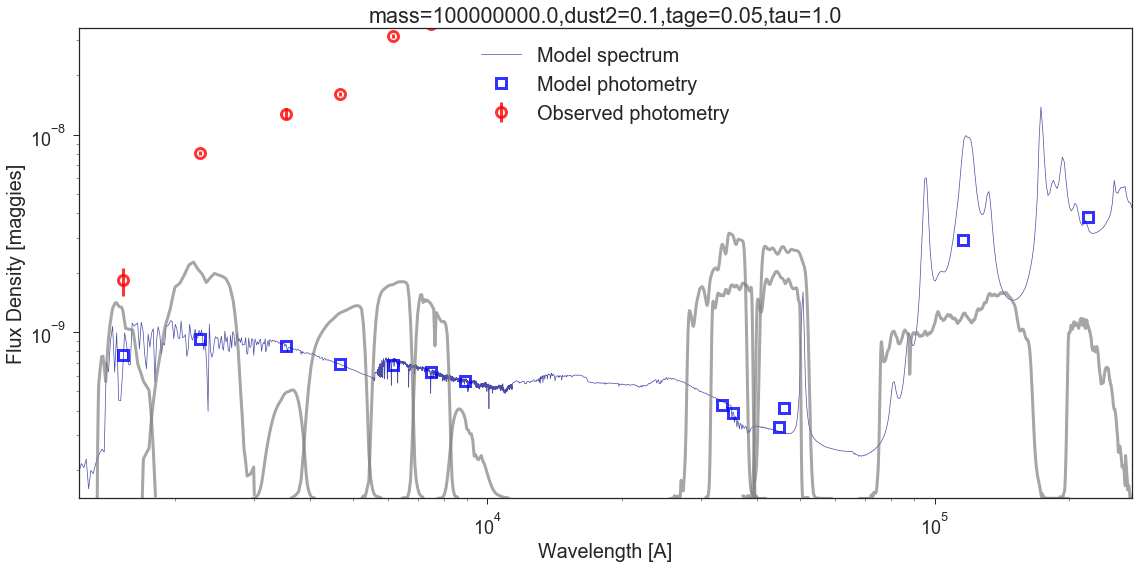

In [19]:
# Generate the model SED at some value of theta
theta = model.theta.copy()
theta[model.theta_index["mass"]] = 1e8
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
# spec, phot, x = sps.get_spectrum(outwave=obs['wavelength'], filters=obs["filters"], **model.params)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Simple maximum-likelihood fitting

In [20]:
from prospect import fitting
from scipy.optimize import least_squares
run_params["nmin"] = 5
run_params['ftol'] = 3e-16 
run_params['maxfev'] = 500
run_params['xtol'] = 3e-16

In [28]:
# --- start minimization ----
min_method = 'levenberg_marquardt'
run_params["min_method"] = min_method

# We'll start minimization from "nmin" separate places, 
# the first based on the "init" values of each parameter and the 
# rest drawn from the prior.  This can guard against local minima.
nmin = run_params["nmin"]
ts = time.time()  # time it
pinitial = fitting.minimizer_ball(model.initial_theta.copy(), nmin, model)
guesses = []
for i, pinit in enumerate(pinitial): #loop over initial guesses
    res = least_squares(chivecfn, np.array(pinit), method='dogbox', x_scale='jac',
                        xtol=run_params["xtol"], ftol=run_params["ftol"], 
                        max_nfev=run_params["maxfev"])
    guesses.append(res)

# Calculate chi-square of the results, and choose the best one
# fitting.reinitialize moves the parameter vector away from edges of the prior.
chisq = [np.sum(r.fun**2) for r in guesses]
best = np.argmin(chisq)
theta_best = fitting.reinitialize(guesses[best].x, model,
                                  edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = None
pdur = time.time() - ts

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} chi-sq: {1}'.format(min_method, chisq[best]))
print('best guess paramaters:')
for k, t in zip(model.theta_labels(), theta_best):
    print('  {} = {}'.format(k, t))

done levenberg_marquardt in 11.192718029022217s
best levenberg_marquardt chi-sq: 351.70295966193385
best guess paramaters:
  mass = 383214100650.0237
  dust2 = 0.7923709876433952
  tage = 6.308937137245593
  tau = 68.79052697323016


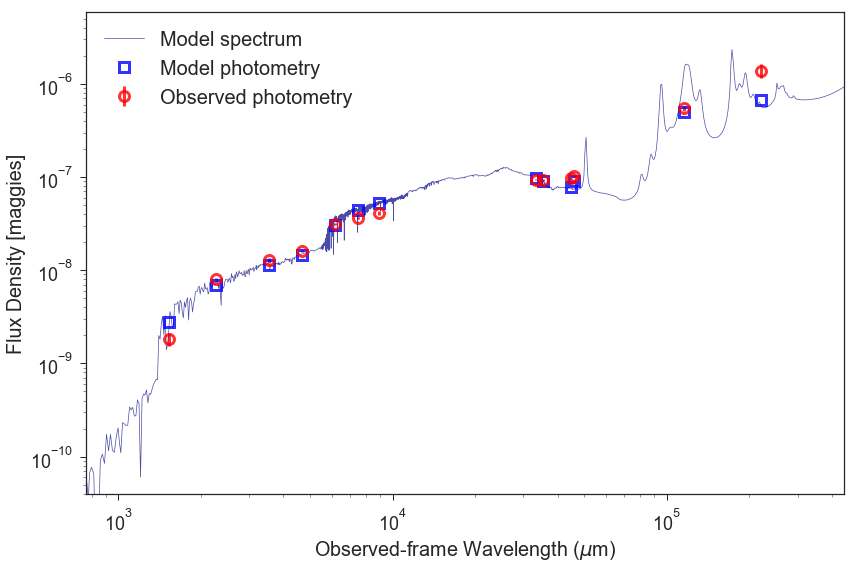

In [31]:
# generate model
prediction = model.mean_model(theta_best, obs, sps=sps)
pspec, pphot, pextra = prediction

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]

if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.5, np.max(wphot)/0.5
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, pspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4    
    
figure(figsize=(12, 8))

loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
#for f in obs['filters']:
#    w, t = f.wavelength.copy(), f.transmission.copy()
#    while t.max() > 1:
#        t /= 10.
#    t = 0.1*(ymax-ymin)*t + ymin
#    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel(r'Observed-frame Wavelength ($\mu$m)')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [ ]:
#np.savetxt('sed.txt', np.array([wspec, pspec]).T)

In [ ]:
wspec